In [198]:
# import os
# import pandas as pd

# def rename_conditional_prob_files(input_dir, output_dir):
#     os.makedirs(output_dir, exist_ok=True)

#     # Map original base names to new names
#     rename_map = {
#         "Gentamicin": "Gentamicin",
#         "Amikacin": "Amikacin",
#         "Piperacillin_tazobactam": "Piperacillin.tazobactam",
#         "Meropenem": "Meropenem",
#         "Amoxycillin_clavulanate": "Amoxycillin.clavulanate",
#         "Ceftazidime": "Ceftazidime",
#         "Tigecycline": "Tigecycline",
#         "Levofloxacin": "Levofloxacin",
#         "Ampicillin": "Ampicillin",
#         "Colistin": "Colistin",
#     }

#     # Create reverse mapping to easily detect the current drug in column names
#     reverse_map = {v: k for k, v in rename_map.items()}

#     for old_name, new_name in rename_map.items():
#         input_file = os.path.join(input_dir, f"conditional_probs_{old_name}_bin_fixed.csv")
#         output_file = os.path.join(output_dir, f"{new_name}_fixed_2.csv")

#         df = pd.read_csv(input_file)

#         # Update column names
#         def rename_column(col):
#             if col.startswith(f"condProb_given_{old_name}_bin_for_"):
#                 target = col.split("_for_")[-1].replace("_bin", "")
#                 target_new = rename_map.get(target, target)
#                 return f"{target_new}_{new_name}_pred_prob"
#             return col

#         df.columns = [rename_column(col) for col in df.columns]

#         df.to_csv(output_file, index=False)

# # Example usage:
# rename_conditional_prob_files(input_dir="../../results/predictions_non_ml/fixed_2", output_dir="../../results/predictions_non_ml/fixed_2")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from math import ceil, sqrt
import numpy as np 

BASE_DIRS   = {
    "fixed": '../../results/predictions_non_ml/fixed', 
    # "fixed_2": '../../results/predictions_non_ml/fixed_2',
    "hier": '../../results/predictions_non_ml/hier',
    "xgb": '../../results/predictions_ml/xgb',
    "xgb_Italy": '../../results/predictions_ml/xgb_Italy',
    "xgb_Spain": '../../results/predictions_ml/xgb_Spain',
    "xgb_Croatia": '../../results/predictions_ml/xgb_Croatia',
    "xgb_Portugal": '../../results/predictions_ml/xgb_Portugal',
    "xgb_Greece": '../../results/predictions_ml/xgb_Greece',
    "xgb_Slovenia": '../../results/predictions_ml/xgb_Slovenia',
    "lr": '../../results/predictions_ml/lr',
    "xls": '../../results/predictions_xls'
    }   # model families → folder
BASE_FILES  = {
    "fixed": "fixed.csv", 
    # "fixed_2": "fixed_2.csv",
    "hier": "hier.csv",
    "xgb": "xgb.csv",
    "xgb_Italy": "xgb_Italy.csv",
    "xgb_Spain": "xgb_Spain.csv",
    "xgb_Croatia": "xgb_Croatia.csv",
    "xgb_Portugal": "xgb_Portugal.csv",
    "xgb_Greece": "xgb_Greece.csv",
    "xgb_Slovenia": "xgb_Slovenia.csv",
    "lr": "lr.csv",
    "xls": "xls.csv"
    }

COUNTRY = [None, 'Italy', 'Spain', 'Croatia', 'Portugal', 'Greece', 'Slovenia']

DRUG_ABBR = {
    "Meropenem": "MER",
    "Piperacillin.tazobactam": "TZP",
    "Ampicillin": "AMP",
    "Tigecycline": "TGC",
    "Gentamicin": "GEN",
    "Amikacin": "AMK",
    "Ceftazidime": "CAZ",
    "Levofloxacin": "LVX",
    "Colistin": "CST",
    "Amoxycillin.clavulanate": "AMC"
}

label_names = {
    "HIER":  "HB-MVP",
    "XGB":   "XGB",
    "LR":    "LR",
    "XLS":   "PA",
}

drug_cols = [
    'Meropenem',
    'Piperacillin.tazobactam', 'Ampicillin', 'Tigecycline',
    'Gentamicin', 'Amikacin', 'Ceftazidime', 'Levofloxacin',
    # 'Colistin', 
    'Amoxycillin.clavulanate'
]

# order drug_cols alphabetically
drug_cols.sort()

palette = sns.color_palette("husl", len(drug_cols))
colour_map = {drug: palette[i] for i, drug in enumerate(drug_cols)}

conditioning_choices = [None] + drug_cols
# conditioning_choices = drug_cols

In [212]:

##############################################################################
# 2-0. Plot ROC curves with AUCs for all conditioning options
##############################################################################

def plot_grid_with_auc(
    roc_dict,
    model_name,
    line_style,
    save_as,
    average_colour="black",
    average_label="Average",
):
    """
    roc_dict   = {conditioning_drug -> {target -> (fpr, tpr, AUC)}}
    model_name = title string
    line_style = "-" (solid) or "--" (dashed)
    """
    n = len(conditioning_choices)
    ncols = 4
    nrows = ceil(n / ncols)
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(ncols * 4.2, nrows * 3.8), sharex=True, sharey=True
    )
    axes = axes.flatten()

    for idx, cond in enumerate(conditioning_choices):
        ax = axes[idx]
        curves = roc_dict[cond]

        # ── 1. Individual drug ROC curves ────────────────────────────────────
        for drug, (fpr, tpr, auc_val) in curves.items():
            ax.plot(
                fpr,
                tpr,
                color=colour_map[drug],
                linestyle=line_style,
                lw=1.2,
            )

        # ── 2. Mean ROC across all targets in this panel ─────────────────────
        if curves:  # skip empty panels
            base_fpr = np.linspace(0.0, 1.0, 101)
            tprs = [np.interp(base_fpr, fpr, tpr) for fpr, tpr, _ in curves.values()]
            mean_tpr = np.mean(tprs, axis=0)
            mean_auc = auc(base_fpr, mean_tpr)

            ax.plot(
                base_fpr,
                mean_tpr,
                color=average_colour,
                linestyle=line_style,
                lw=2.4,
                label=average_label,
            )

        # ── 3. Formatting & AUC annotation ───────────────────────────────────
        ax.plot([0, 1], [0, 1], "--", lw=0.5, color="grey")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title("None" if cond is None else cond, fontsize=8)

        auc_lines = [
            f"{drug}: {auc_val:.2f}"
            for drug, (_, _, auc_val) in sorted(curves.items(), key=lambda x: x[0])
        ]
        if curves:
            auc_lines.append(f"{average_label}: {mean_auc:.2f}")

        ax.text(
            0.98,
            0.02,
            "\n".join(auc_lines),
            transform=ax.transAxes,
            fontsize=8,
            va="bottom",
            ha="right",
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.6, lw=0),
        )

    # ── 4. Clean up & global decorations ────────────────────────────────────
    for ax in axes[n:]:
        ax.axis("off")

    fig.suptitle(f"ROC curves – {model_name}", fontsize=16, y=0.93)
    fig.text(0.5, 0.04, "False Positive Rate", ha="center")
    fig.text(0.04, 0.5, "True Positive Rate", va="center", rotation="vertical")

    # legend: individual drugs + the average curve
    handles = [plt.Line2D([0], [0], color=colour_map[d], lw=2) for d in drug_cols]
    handles.append(plt.Line2D([0], [0], color=average_colour, lw=2.4))
    labels = drug_cols + [average_label]

    fig.legend(
        handles,
        labels,
        ncol=5,
        fontsize="x-small",
        loc="lower center",
        bbox_to_anchor=(0.5, -0.02),
    )

    fig.tight_layout(rect=[0.03, 0.05, 0.97, 0.9])
    plt.savefig(save_as, dpi=300, bbox_inches="tight")
    plt.show()

In [213]:
def plot_mean_rocs_only(
    roc_dict,
    model_name,
    line_style,
    save_as,
    average_colour="black",
    average_label="Average",
):
    """
    Plot a single ROC figure that contains only the *mean* ROC curve
    of every conditioning panel in `roc_dict`.

    Parameters
    ----------
    roc_dict : dict
        {conditioning_drug -> {target -> (fpr, tpr, AUC)}}
    model_name : str
        Title string shown on the figure.
    save_as : str or Path
        Where to save the PNG/PDF.
    conditioning_choices : list
        Ordered list of keys to pull from roc_dict (keeps colours consistent).
    average_colour : str
        Colour used for the overall average line (optional).
    """
    # ── 1. Collate all mean curves ──────────────────────────────────────────
    base_fpr = np.linspace(0.0, 1.0, 101)
    mean_curves, mean_aucs = {}, {}

    for cond in conditioning_choices:
        curves = roc_dict[cond]
        if not curves:          # skip empty panels
            continue

        tprs = [np.interp(base_fpr, fpr, tpr) for fpr, tpr, _ in curves.values()]
        mean_tpr = np.mean(tprs, axis=0)
        mean_auc = auc(base_fpr, mean_tpr)

        mean_curves[cond] = mean_tpr
        mean_aucs[cond]  = mean_auc

    # ── 2. Plot ─────────────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(5, 5))

    for cond in conditioning_choices:
        if cond not in mean_curves:
            continue                             # skipped empty one

        label = f"{cond if cond is not None else 'None'}  (AUC ={mean_aucs[cond]:.2f})"
        ax.plot(
            base_fpr,
            mean_curves[cond],
            color=colour_map.get(cond, "tab:grey"),
            lw=2,
            label=label,
        )

    # Optional overall average across *all* conditioning options
    if mean_curves:
        overall_tpr = np.mean(list(mean_curves.values()), axis=0)
        overall_auc = auc(base_fpr, overall_tpr)
        ax.plot(
            base_fpr,
            overall_tpr,
            color=average_colour,
            lw=3,
            ls="--",
            label=f"Overall average (AUC ={overall_auc:.2f})",
        )

    # ── 3. Cosmetics ────────────────────────────────────────────────────────
    ax.plot([0, 1], [0, 1], "--", lw=0.6, color="grey")
    ax.set_xlim(0, 1);  ax.set_ylim(0, 1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"Mean ROC per conditioning option – {model_name}", fontsize=14)
    ax.legend(fontsize=8, loc="lower right")
    fig.tight_layout()

    plt.savefig(save_as, dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
# from collections import defaultdict
# from sklearn.metrics import auc

# def plot_mean_rocs_by_target(
#     roc_dict,
#     model_name,
#     line_style,               # kept for call‑site compatibility, not used
#     save_as,
#     conditioning_choices=None,
#     average_colour="black",
#     average_label="Average",
# ):
#     """
#     Aggregate ROC curves *by target drug* (averaging across conditioning drugs)
#     and plot a single figure with one mean ROC per target.

#     Parameters
#     ----------
#     roc_dict : dict
#         {conditioning_drug -> {target -> (fpr, tpr, AUC)}}
#     model_name : str
#         Label for figure title.
#     save_as : str or Path
#         Output file path.
#     conditioning_choices : list, optional
#         Subset or ordering of conditioning keys to scan.  If None, uses all keys
#         present in `roc_dict`.
#     """
#     if conditioning_choices is None:
#         conditioning_choices = list(roc_dict.keys())

#     # ── 1. Collect curves target‑wise ───────────────────────────────────────
#     base_fpr = np.linspace(0.0, 1.0, 101)
#     tpr_buckets = defaultdict(list)      # target -> list of interpolated TPRs

#     for cond in conditioning_choices:
#         for tgt, (fpr, tpr, _) in roc_dict[cond].items():
#             tpr_buckets[tgt].append(np.interp(base_fpr, fpr, tpr))

#     if not tpr_buckets:
#         raise ValueError("No valid curves found to plot.")

#     mean_curves = {
#         tgt: np.mean(tprs, axis=0) for tgt, tprs in tpr_buckets.items()
#     }
#     mean_aucs = {
#         tgt: auc(base_fpr, mean_curves[tgt]) for tgt in mean_curves
#     }

#     # ── 2. Plot ─────────────────────────────────────────────────────────────
#     fig, ax = plt.subplots(figsize=(5, 6))

#     for tgt, mean_tpr in mean_curves.items():
#         ax.plot(
#             base_fpr,
#             mean_tpr,
#             color=colour_map.get(tgt, "tab:grey"),
#             lw=1.5,
#             label=f"{tgt}  (AUC ={mean_aucs[tgt]:.2f})",
#         )

#     # Optional overall average across targets
#     overall_tpr = np.mean(list(mean_curves.values()), axis=0)
#     overall_auc = auc(base_fpr, overall_tpr)
#     ax.plot(
#         base_fpr,
#         overall_tpr,
#         color=average_colour,
#         lw=1.5,
#         ls="--",
#         label=f"{average_label} (AUC ={overall_auc:.2f})",
#     )

#     # ── 3. Cosmetics ────────────────────────────────────────────────────────
#     ax.plot([0, 1], [0, 1], "--", lw=0.6, color="grey")
#     ax.set_xlim(0, 1); ax.set_ylim(0, 1)
#     ax.set_xlabel("False Positive Rate")
#     ax.set_ylabel("True Positive Rate")
#     ax.set_title(f"Mean ROC per target drug – {model_name}", fontsize=14)
#     ax.legend(fontsize=8, loc="lower right")
#     fig.tight_layout()

#     plt.savefig(save_as, dpi=300, bbox_inches="tight")
#     plt.show()


In [234]:
from collections import defaultdict
from sklearn.metrics import auc

def plot_mean_rocs_by_target(
    roc_dict,
    model_name,
    line_style,               # placeholder for compatibility
    save_as,
    conditioning_choices=None,
    average_colour="black",
    average_label="Average",
):
    """
    Plot unconditional (cond=None) and conditional (cond!=None) mean ROCs
    for every target drug side by side.

    Parameters
    ----------
    roc_dict : dict
        {conditioning_drug -> {target -> (fpr, tpr, AUC)}}.
        Must contain the key `None` for the unconditional model.
    model_name : str
        Figure‑title label.
    save_as : str or Path
        Output file path.
    conditioning_choices : list, optional
        Ordering / subset of conditioning keys to scan; defaults to all keys.
    """
    if conditioning_choices is None:
        conditioning_choices = list(roc_dict.keys())

    if None not in roc_dict:
        raise ValueError("Unconditional curves not found (key `None` missing).")

    base_fpr = np.linspace(0.0, 1.0, 101)

    # ── 1. Unconditional curves (no averaging needed) ───────────────────────
    uncond_curves = {}
    uncond_aucs   = {}
    for tgt, (fpr, tpr, _) in roc_dict[None].items():
        interp_tpr          = np.interp(base_fpr, fpr, tpr)
        uncond_curves[tgt]  = interp_tpr
        uncond_aucs[tgt]    = auc(base_fpr, interp_tpr)

    # ── 2. Conditional mean curves (average over cond != None) ──────────────
    cond_tpr_buckets = defaultdict(list)
    for cond in conditioning_choices:
        if cond is None:
            continue
        for tgt, (fpr, tpr, _) in roc_dict[cond].items():
            cond_tpr_buckets[tgt].append(np.interp(base_fpr, fpr, tpr))

    if not cond_tpr_buckets:
        raise ValueError("No conditional curves found to plot.")

    cond_curves = {tgt: np.mean(tprs, axis=0) for tgt, tprs in cond_tpr_buckets.items()}
    cond_aucs   = {tgt: auc(base_fpr, cond_curves[tgt]) for tgt in cond_curves}

    # ── 3. Plot ─────────────────────────────────────────────────────────────
    fig, axes = plt.subplots(1, 2, figsize=(7, 5), sharex=True, sharey=True)
    ax_u, ax_c = axes

    # (a) Unconditional panel
    for tgt, tpr in uncond_curves.items():
        ax_u.plot(
            base_fpr,
            tpr,
            color=colour_map.get(tgt, "tab:grey"),
            lw=1.2,
            label=f"{DRUG_ABBR.get(tgt)} (AUC ={uncond_aucs[tgt]:.2f})",
        )
    overall_u = np.mean(list(uncond_curves.values()), axis=0)
    # ax_u.plot(base_fpr, overall_u, color=average_colour, lw=1.2, ls="--",
    #           label=f"{average_label} (AUC={auc(base_fpr, overall_u):.2f})")

    # (b) Conditional panel
    for tgt, tpr in cond_curves.items():
        ax_c.plot(
            base_fpr,
            tpr,
            color=colour_map.get(tgt, "tab:grey"),
            lw=1.2,
            label=f"{DRUG_ABBR.get(tgt)} (AUC ={cond_aucs[tgt]:.2f})",
        )
    overall_c = np.mean(list(cond_curves.values()), axis=0)
    # ax_c.plot(base_fpr, overall_c, color=average_colour, lw=1.2, ls="--",
    #           label=f"{average_label} (AUC={auc(base_fpr, overall_c):.2f})")

    # ── 4. Cosmetics ────────────────────────────────────────────────────────
    for ax, title in zip((ax_u, ax_c),
                         (f"{label_names.get(model_name)} - Unconditional",
                          f"{label_names.get(model_name)} - Conditional (mean)")):
        ax.plot([0, 1], [0, 1], "--", lw=0.6, color="grey")
        ax.set_xlim(0, 1); ax.set_ylim(0, 1)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(title, fontsize=12)
        ax.legend(fontsize=7, loc="lower right")

    fig.suptitle(f"ROC curves by target drug", fontsize=14, y=0.98)
    fig.tight_layout(rect=[0, 0.03, 1, 0.96])

    plt.savefig(save_as, dpi=300, bbox_inches="tight")
    plt.show()


Loading fixed family, conditioning drug: None, file: ../../results/predictions_non_ml/fixed/fixed.csv
Loading fixed family, conditioning drug: Amikacin, file: ../../results/predictions_non_ml/fixed/Amikacin_fixed.csv
Loading fixed family, conditioning drug: Amoxycillin.clavulanate, file: ../../results/predictions_non_ml/fixed/Amoxycillin.clavulanate_fixed.csv
Loading fixed family, conditioning drug: Ampicillin, file: ../../results/predictions_non_ml/fixed/Ampicillin_fixed.csv
Loading fixed family, conditioning drug: Ceftazidime, file: ../../results/predictions_non_ml/fixed/Ceftazidime_fixed.csv
Loading fixed family, conditioning drug: Gentamicin, file: ../../results/predictions_non_ml/fixed/Gentamicin_fixed.csv
Loading fixed family, conditioning drug: Levofloxacin, file: ../../results/predictions_non_ml/fixed/Levofloxacin_fixed.csv
Loading fixed family, conditioning drug: Meropenem, file: ../../results/predictions_non_ml/fixed/Meropenem_fixed.csv
Loading fixed family, conditioning drug

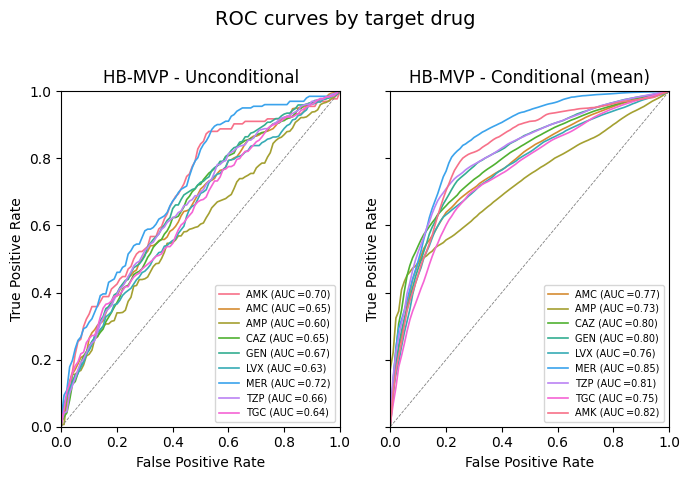

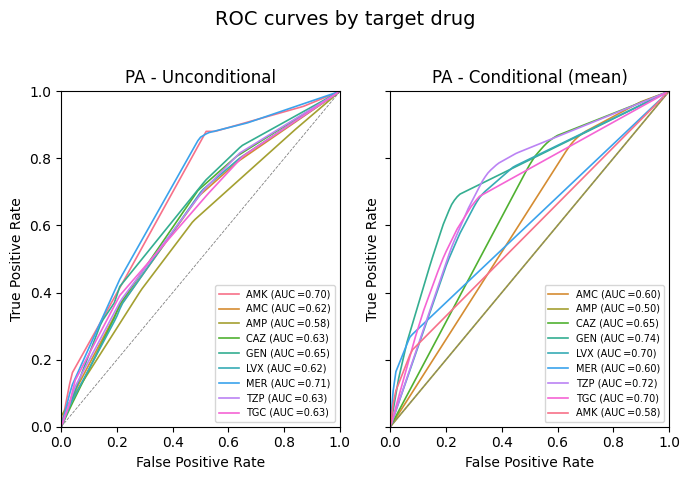

In [235]:
##############################################################################
# 2-1.  PATHS – change if your folders live elsewhere
##############################################################################

import os, re, pandas as pd
from sklearn.metrics import roc_curve, auc
import numpy as np

##############################################################################
# 2.  Small helpers
##############################################################################
def _prob_col(target, cond, family):
    """
    Return the column name holding predicted probabilities.
    Naming rules (from your friend’s files):
       • base model:          "{target}_pred_prob"        (no conditioning)
       • conditional models:  "{target}_{cond}_pred_prob"
    A few files use a *double* underscore (`__pred_prob`) – we normalise that here.
    """
    raw = (
        f"{target}_pred_prob" if cond is None
        else f"{target}_{cond}_pred_prob"
    )
    
    return re.sub(r"__pred_prob$", "_pred_prob", raw)     # safety

def _load_frame(family, cond):
    """family ∈ {'fixed','hier'}  |  cond ∈ {None,*drug_cols}"""
    fname = BASE_FILES[family] if cond is None else f"{cond}_{family}.csv"
    path  = os.path.join(BASE_DIRS[family], fname)
    print(f"Loading {family} family, conditioning drug: {cond}, file: {path}")

    if not os.path.exists(path):
        raise FileNotFoundError(path)
    
    df = pd.read_csv(path)

    # select only the rows for the specified country
    # if COUNTRY != None and "country" in df.columns:
    #     df = df[df["country"] == COUNTRY]
        

    return df

##############################################################################
# 3.  Build ROC‑curve stores (one per model family)
##############################################################################
def curves_for_family(family):
    curve_store   = {}
    targets_store = {}
    for cond in conditioning_choices:
        df   = _load_frame(family, cond)
        tgs  = [d for d in drug_cols if d != cond]        # never predict the conditioning drug
        curves = {}
        for tgt in tgs:
            y_true = df[f"{tgt}_bin"].values
            if len(np.unique(y_true)) < 2:                # skip uninformative ROC
                continue
            prob_col = _prob_col(tgt, cond, family)
            if prob_col not in df.columns:
                # fall back to hard‑label if probabilities missing
                probas = df[f"{tgt}_pred_y"].values
            else:
                probas = df[prob_col].values
            fpr, tpr, _ = roc_curve(y_true, probas)
            curves[tgt] = (fpr, tpr, auc(fpr, tpr))
        curve_store[cond] = curves
        targets_store[cond] = tgs
    return curve_store, targets_store

roc_store_fixed, _ = curves_for_family("fixed")
# roc_store_fixed_2, _ = curves_for_family("fixed_2")
roc_store_hier , _ = curves_for_family("hier")
roc_store_xgb  , _ = curves_for_family("xgb")
roc_store_lr   , _ = curves_for_family("lr")
roc_store_xls , _ = curves_for_family("xls")

roc_store_xgb_Italy   , _ = curves_for_family("xgb_Italy")
roc_store_xgb_Spain   , _ = curves_for_family("xgb_Spain")
roc_store_xgb_Croatia , _ = curves_for_family("xgb_Croatia")
roc_store_xgb_Portugal, _ = curves_for_family("xgb_Portugal")
roc_store_xgb_Greece  , _ = curves_for_family("xgb_Greece")
roc_store_xgb_Slovenia, _ = curves_for_family("xgb_Slovenia")

##############################################################################
# 4.  Plot!  (re‑using your existing helper)
##############################################################################

# plot_mean_rocs_only(
#     roc_store_fixed, "FIXED", "-", "grid_roc_fixed_auc.png"
# )

# plot_grid_with_auc(
#     roc_store_fixed_2, "FIXED 2", "-", "grid_roc_fixed_2_auc.png"
# )

plot_mean_rocs_by_target(
    roc_store_hier,  "HIER", "-", "grid_roc_hier_auc.png"
)

# plot_mean_rocs_by_target(
#     roc_store_xgb,   "XGBoost", "-", "grid_roc_xgb_auc.png",
#     average_colour="black", average_label="XGB Average"
# )

# plot_mean_rocs_only(
#     roc_store_xgb_Italy,   "XGBoost Italy", "-", "grid_roc_xgb_italy_auc.png",
#     average_colour="black", average_label="XGB Italy Average"
# )

# plot_mean_rocs_only(
#     roc_store_xgb_Spain,   "XGBoost Spain", "-", "grid_roc_xgb_spain_auc.png",
#     average_colour="black", average_label="XGB Spain Average"
# )

# plot_mean_rocs_only(
#     roc_store_xgb_Croatia,   "XGBoost Croatia", "-", "grid_roc_xgb_croatia_auc.png",
#     average_colour="black", average_label="XGB Croatia Average"
# )

# plot_mean_rocs_only(
#     roc_store_xgb_Portugal,   "XGBoost Portugal", "-", "grid_roc_xgb_portugal_auc.png",
#     average_colour="black", average_label="XGB Portugal Average"
# )

# plot_mean_rocs_only(
#     roc_store_xgb_Greece,   "XGBoost Greece", "-", "grid_roc_xgb_greece_auc.png",
#     average_colour="black", average_label="XGB Greece Average"
# )

# plot_mean_rocs_only(
#     roc_store_xgb_Slovenia,   "XGBoost Slovenia", "-", "grid_roc_xgb_slovenia_auc.png",
#     average_colour="black", average_label="XGB Slovenia Average"
# )

# plot_mean_rocs_by_target(
#     roc_store_lr,    "Logistic Regression", "-", "grid_roc_lr_auc.png",
#     average_colour="black", average_label="LR Average"
# )

plot_mean_rocs_by_target(
    roc_store_xls,   "XLS", "-", "grid_roc_xls_auc.png",
    average_colour="black", average_label="XLS Average"
)


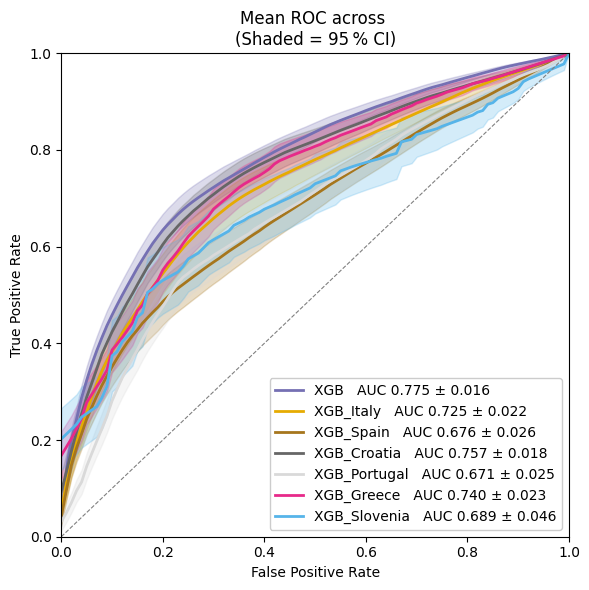

In [5]:
##############################################################################
# 5.  Unified mean ROC plot (four model families) – with 95 % CI #############
##############################################################################
import matplotlib.pyplot as plt
import numpy as np

# ── 5‑A.  Collect all TPR curves on a common FPR grid -----------------------
family_stores = {
    # "FIXED": roc_store_fixed,
    # "HIER":  roc_store_hier,
    "XGB":   roc_store_xgb,
    "XGB_Italy": roc_store_xgb_Italy,
    "XGB_Spain": roc_store_xgb_Spain,
    "XGB_Croatia": roc_store_xgb_Croatia,
    "XGB_Portugal": roc_store_xgb_Portugal,
    "XGB_Greece": roc_store_xgb_Greece,
    "XGB_Slovenia": roc_store_xgb_Slovenia,
    # "LR":    roc_store_lr,
    # "XLS":   roc_store_xls,
}

# choose distinct, colour‑blind‑friendly colours
family_colours = {
    # "FIXED": "#1b9e77",   # green‑ish
    # "HIER":  "#d95f02",   # orange
    "XGB":   "#7570b3",   # purple
    "XGB_Italy": "#e6ab02",   # yellow
    "XGB_Spain": "#a6761d",   # brown
    "XGB_Croatia": "#666666",   # grey
    "XGB_Portugal": "#d9d9d9",   # light grey
    "XGB_Greece": "#e7298a",   # pink
    "XGB_Slovenia": "#56b4e9",   # dark purple
    # "LR":    "#e7298a",   # pink
    # "XLS":   "#66a61e",   # light green
}

base_fpr = np.linspace(0.0, 1.0, 101)   # common x‑axis for interpolation
fig, ax = plt.subplots(figsize=(6, 6))

handles, labels = [], []

for fam, store in family_stores.items():
    tprs, auc_vals = [], []

    for cond_dict in store.values():          # iterate over conditioning choices
        for fpr, tpr, auc_val in cond_dict.values():     # iterate over targets
            tprs.append(np.interp(base_fpr, fpr, tpr))
            auc_vals.append(auc_val)

    tprs = np.vstack(tprs)                    # shape: (n_curves, 101)

    mean_tpr = tprs.mean(axis=0)
    se_tpr   = tprs.std(axis=0, ddof=1) / np.sqrt(tprs.shape[0])
    ci_low   = np.maximum(mean_tpr - 1.96 * se_tpr, 0)
    ci_high  = np.minimum(mean_tpr + 1.96 * se_tpr, 1)

    ax.plot(
        base_fpr, mean_tpr,
        label=fam,
        color=family_colours[fam],
        lw=2,
    )
    ax.fill_between(
        base_fpr, ci_low, ci_high,
        color=family_colours[fam],
        alpha=0.25,
    )

    # legend entry with mean AUC ± 95 % CI
    mean_auc = np.mean(auc_vals)
    se_auc   = np.std(auc_vals, ddof=1) / np.sqrt(len(auc_vals))
    handles.append(plt.Line2D([0], [0], color=family_colours[fam], lw=2))
    labels.append(f"{fam}   AUC {mean_auc:.3f} ± {1.96*se_auc:.3f}")

# ── 5‑B.  Final figure polish ----------------------------------------------
ax.plot([0, 1], [0, 1], "--", color="grey", lw=0.8)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Mean ROC across \n(Shaded = 95 % CI)")
ax.legend(handles, labels, loc="lower right", framealpha=1)
plt.tight_layout()
plt.savefig("roc_mean_with_ci.png", dpi=300)
plt.show()


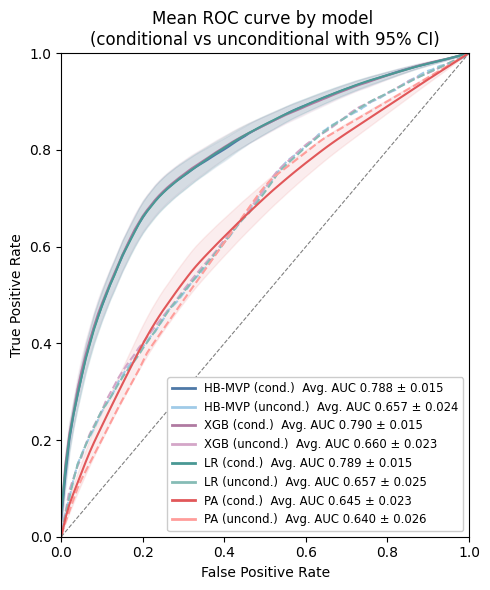

In [188]:
##############################################################################
# 5.  Unified mean ROC plot  – base vs conditioned (95 % CI) #################
##############################################################################
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ── 5‑A.  Prep colour pairs and stores --------------------------------------
colours = ["#4E79A7", '#A0CBE8','#B07AA1', '#D4A6C8', '#499894', '#86BCB6',  '#E15759','#FF9D9A', '#59A14F', "#8CD17D",]
# 
families = ["HIER", "XGB", "LR", "XLS"]

family_stores = {
    # "FIXED": roc_store_fixed,
    "HIER":  roc_store_hier,
    "XGB":   roc_store_xgb,
    "LR":    roc_store_lr,
    "XLS":   roc_store_xls,
}

label_names = {
    "HIER":  "HB-MVP",
    "XGB":   "XGB",
    "LR":    "LR",
    "XLS":   "PA",
}

# map: family → (light_colour, dark_colour)
family_colours = {
    fam: (colours[i*2+1], colours[i*2])       # lighter first, darker second
    for i, fam in enumerate(families)
}

base_fpr = np.linspace(0.0, 1.0, 101)        # common x‑axis
fig, ax = plt.subplots(figsize=(5, 6))
handles, labels = [], []

# ── 5‑B.  Loop over model families ------------------------------------------
for fam in families:
    store = family_stores[fam]
    light, dark = family_colours[fam]

    # ----- (i)  UNCONDITIONED (“None”) --------------------------------------
    if None not in store:
        raise KeyError(f"'None' key missing for {fam}")

    tprs_null, auc_null = [], []
    for fpr, tpr, auc_val in store[None].values():
        tprs_null.append(np.interp(base_fpr, fpr, tpr))
        auc_null.append(auc_val)

    tprs_null = np.vstack(tprs_null)
    mean_null = tprs_null.mean(axis=0)
    se_null   = tprs_null.std(axis=0, ddof=1) / np.sqrt(tprs_null.shape[0])
    ci_lo_n   = np.maximum(mean_null - 1.96*se_null, 0)
    ci_hi_n   = np.minimum(mean_null + 1.96*se_null, 1)

    ax.plot(
        base_fpr, mean_null, color=light, alpha=1, lw=1.5, linestyle="--",
        label=f"{label_names.get(fam)} (uncond.)"
    )
    # ax.fill_between(base_fpr, ci_lo_n, ci_hi_n, color=light, alpha=0.1)

    # ----- (ii) CONDITIONED (all non‑None averaged) ------------------------
    tprs_c, auc_c = [], []
    for cond, cond_dict in store.items():
        if cond is None:
            continue
        for fpr, tpr, auc_val in cond_dict.values():
            tprs_c.append(np.interp(base_fpr, fpr, tpr))
            auc_c.append(auc_val)

    tprs_c = np.vstack(tprs_c)
    mean_c = tprs_c.mean(axis=0)
    se_c   = tprs_c.std(axis=0, ddof=1) / np.sqrt(tprs_c.shape[0])
    ci_lo_c = np.maximum(mean_c - 1.96*se_c, 0)
    ci_hi_c = np.minimum(mean_c + 1.96*se_c, 1)

    ax.plot(
        base_fpr, mean_c, color=dark, lw=1.5, alpha=1, linestyle="-",
        label=f"{label_names.get(fam)} (cond.)"
    )
    ax.fill_between(base_fpr, ci_lo_c, ci_hi_c, color=dark, alpha=0.1)

    # legend handles with AUC ± CI
    def _auc_entry(col, aucs, tag):
        m  = np.mean(aucs)
        se = np.std(aucs, ddof=1) / np.sqrt(len(aucs))
        handles.append(plt.Line2D([0], [0], color=col, lw=2))
        labels.append(f"{label_names.get(fam)} {tag}  Avg. AUC {m:.3f} ± {1.96*se:.3f}")
    
    _auc_entry(dark , auc_c,    "(cond.)")
    _auc_entry(light, auc_null, "(uncond.)")


# ── 5‑C.  Final figure polish ----------------------------------------------
ax.plot([0, 1], [0, 1], "--", color="grey", lw=0.8)
ax.set_xlim(0, 1);  ax.set_ylim(0, 1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Mean ROC curve by model \n(conditional vs unconditional with 95% CI)")
ax.legend(handles, labels, fontsize="small", framealpha=1, loc="lower right")

plt.tight_layout()
plt.savefig("roc_mean_base_vs_conditioned.png", dpi=300)
plt.show()


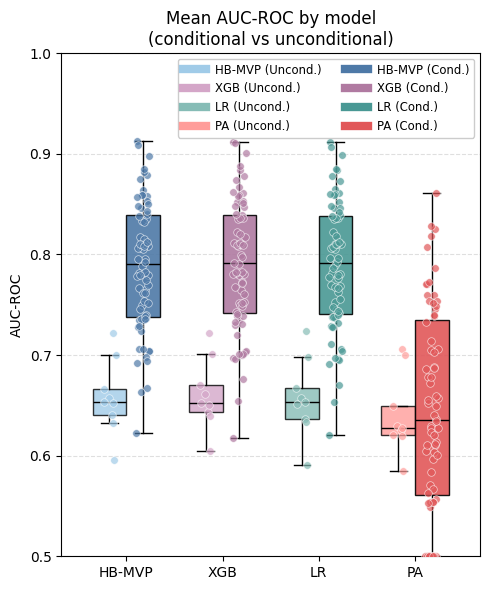

In [185]:
##############################################################################
# 6.  Box‑and‑whisker summary of AUC distributions ###########################
##############################################################################
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

label_names = {
    "HIER":  "HB-MVP",
    "XGB":   "XGB",
    "LR":    "LR",
    "XLS":   "PA",
}

# ── 6‑A.  Build a long‑form DataFrame of all AUCs ---------------------------
rows = []
for fam in families:                       # families list from block 5
    store = family_stores[fam]

    # (i) unconditioned (“None”)
    auc_null = [auc_val for (_, _, auc_val) in store[None].values()]
    rows += [{"family": fam, "condition": "Uncond.", "auc": a} for a in auc_null]

    # (ii) conditioned – concatenate all non‑None slices
    auc_cond = []
    for cond, cond_dict in store.items():
        if cond is None:
            continue
        auc_cond += [auc_val for (_, _, auc_val) in cond_dict.values()]
    rows += [{"family": fam, "condition": "Cond.", "auc": a} for a in auc_cond]

df_auc = pd.DataFrame(rows)

# ── 6‑B.  Plot: one pair (Uncond./Cond.) per model family -------------------
plt.figure(figsize=(5, 6))
ax = plt.gca()

box_width = 0.35
jitter    = 0.07                       # horizontal jitter for scatter

for i, fam in enumerate(families):
    light, dark = family_colours[fam]  # same paired colours from block 5

    # pull the data back out
    data_un = df_auc.query("family == @fam and condition == 'Uncond.'")["auc"].values
    data_co = df_auc.query("family == @fam and condition == 'Cond.'")["auc"].values

    # ----- boxplots --------------------------------------------------------
    pos_un = i - box_width / 2
    pos_co = i + box_width / 2

    bp_un = ax.boxplot(
        data_un, positions=[pos_un], widths=box_width, patch_artist=True,
        showcaps=True, boxprops=dict(facecolor=light, alpha=0.8, edgecolor="black"),
        medianprops=dict(color="black"), whiskerprops=dict(color="black"),
        showfliers=False
    )
    bp_co = ax.boxplot(
        data_co, positions=[pos_co], widths=box_width, patch_artist=True,
        showcaps=True, boxprops=dict(facecolor=dark, alpha=0.9, edgecolor="black"),
        medianprops=dict(color="black"), whiskerprops=dict(color="black"),
        showfliers=False
    )

    # ----- scatter overlay for conditioned AUCs ---------------------------
    rng = np.random.default_rng(42)    # reproducible jitter
    x_scatter = pos_un + rng.uniform(-jitter, jitter, size=len(data_un))
    ax.scatter(
        x_scatter, data_un,
        color=light, edgecolors="white", linewidth=0.5, alpha=0.7, s=30, zorder=3
    )

    x_scatter = pos_co + rng.uniform(-jitter, jitter, size=len(data_co))
    ax.scatter(
        x_scatter, data_co,
        color=dark, edgecolors="white", linewidth=0.5, alpha=0.7, s=30, zorder=3
    )


# ── 6‑C.  Final formatting --------------------------------------------------
ax.set_xticks(range(len(families)))
ax.set_xticklabels(label_names.values())
ax.set_ylabel("AUC‑ROC")
ax.set_title("Mean AUC-ROC by model\n(conditional vs unconditional)")
ax.set_ylim(0, 1)
ax.grid(axis="y", linestyle="--", alpha=0.4)

# custom legend – only one entry per colour/shade
handles = [
    plt.Line2D([0], [0], lw=6, color=family_colours[fam][0]) for fam in families
] + [
    plt.Line2D([0], [0], lw=6, color=family_colours[fam][1]) for fam in families
]
labels  = [f"{label_names.get(fam)} (Uncond.)" for fam in families] + [f"{label_names.get(fam)} (Cond.)" for fam in families]
ax.legend(handles, labels, fontsize="small", ncol=2, framealpha=1, loc="upper right")
ax.set_ylim(0.5, 1.0)

plt.tight_layout()
plt.savefig("auc_boxplot_uncond_vs_cond.png", dpi=300)
plt.show()


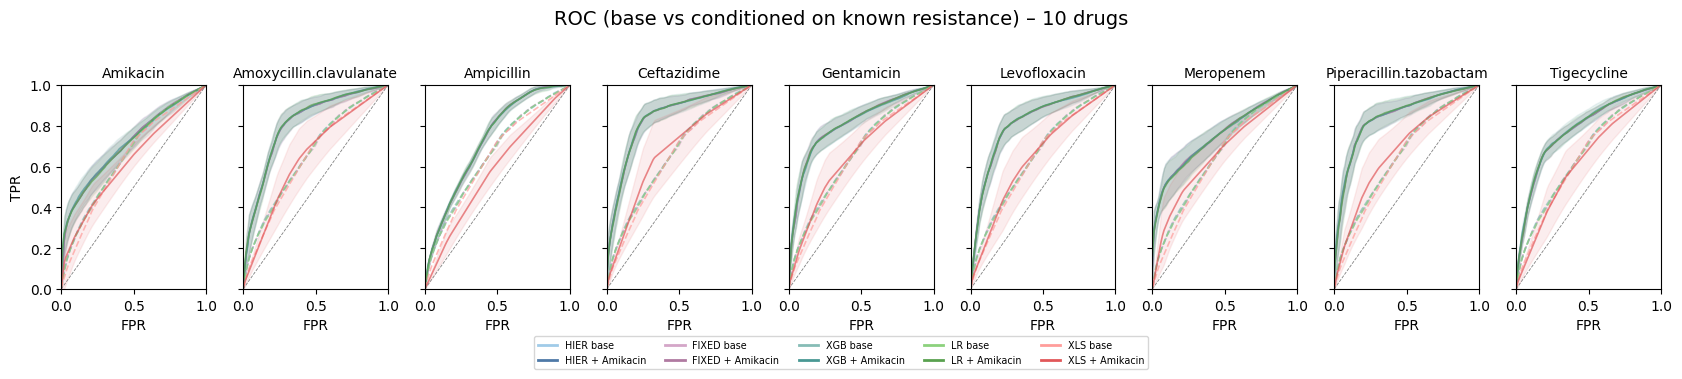

In [81]:
##############################################################################
# 5.  Mean ROC – “base” vs “conditioned on X”  (10 sub‑plots) ###############
##############################################################################
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

# ── 5‑A.  Prep  -------------------------------------------------------------
colours  = ["#4E79A7", '#A0CBE8','#B07AA1', '#D4A6C8', '#499894', '#86BCB6',
            '#59A14F', "#8CD17D", '#E15759','#FF9D9A']
families = ["HIER", "FIXED", "XGB", "LR", "XLS"]
family_stores = {
    "FIXED": roc_store_fixed,
    "HIER":  roc_store_hier,
    "XGB":   roc_store_xgb,
    "LR":    roc_store_lr,
    "XLS":   roc_store_xls,
}
family_colours = {f: (colours[i*2+1], colours[i*2]) for i, f in enumerate(families)}

# choose 10 conditioning drugs
cond_drugs = sorted(drug_cols)[:10]
n_panels   = len(cond_drugs)
ncols, nrows = 9, 1
base_fpr = np.linspace(0.0, 1.0, 101)

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(2 * ncols, 3.8 * nrows),
    sharex=True, sharey=True,
)
axes = axes.flatten()
legend_handles, legend_labels = [], []

# ── 5‑B.  Loop over conditioning drugs -------------------------------------
for idx, cond in enumerate(cond_drugs):
    ax = axes[idx]
    for fam in families:
        store          = family_stores[fam]
        light, dark    = family_colours[fam]

        # (i) UNCONDITIONED (None)
        tprs_n, auc_n  = [], []
        for fpr, tpr, auc_val in store[None].values():
            tprs_n.append(np.interp(base_fpr, fpr, tpr))
            auc_n.append(auc_val)
        tprs_n = np.vstack(tprs_n)
        mean_n = np.vstack(tprs_n).mean(axis=0)
        se_n   = tprs_n.std(axis=0, ddof=1) / np.sqrt(tprs_n.shape[0])
        ci_lo_n = np.maximum(mean_n - 1.96*se_n, 0)
        ci_hi_n = np.minimum(mean_n + 1.96*se_n, 1)

        ax.plot(base_fpr, mean_n, color=light, lw=1.2, linestyle="--", alpha=0.7, 
                label=f"{fam} (uncond.)")
        
        # ax.fill_between(base_fpr, ci_lo_n, ci_hi_n, color=light, alpha=0.1)

        # (ii) CONDITIONED ON <cond>
        if cond not in store:
            continue          # skip if models don’t exist for this drug
        tprs_c, auc_c = [], []
        for fpr, tpr, auc_val in store[cond].values():
            tprs_c.append(np.interp(base_fpr, fpr, tpr))
            auc_c.append(auc_val)
        tprs_c = np.vstack(tprs_c)
        mean_c = np.vstack(tprs_c).mean(axis=0)
        se_c   = tprs_c.std(axis=0, ddof=1) / np.sqrt(tprs_c.shape[0])
        ci_lo_c = np.maximum(mean_c - 1.96*se_c, 0)
        ci_hi_c = np.minimum(mean_c + 1.96*se_c, 1)

        ax.plot(base_fpr, mean_c, color=dark,  lw=1.2, linestyle="-",  alpha=0.7, 
                label=f"{fam} (cond.)")
        
        ax.fill_between(base_fpr, ci_lo_c, ci_hi_c, color=dark, alpha=0.1)

        # one legend handle per family (added once)
        if idx == 0:
            legend_handles += [
                plt.Line2D([0], [0], color=light, lw=2),
                plt.Line2D([0], [0], color=dark,  lw=2),
            ]
            legend_labels  += [
                f"{fam} base",
                f"{fam} + {cond}",
            ]

    ax.plot([0, 1], [0, 1], "--", lw=0.6, color="grey")
    ax.set_title(cond, fontsize=10)
    if idx % ncols == 0:
        ax.set_ylabel("TPR")
    if idx >= (nrows - 1) * ncols:
        ax.set_xlabel("FPR")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# blank any unused axes (when <10 drugs)
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

fig.legend(
    legend_handles, legend_labels,
    ncol=len(families),
    fontsize="x-small",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.02),
)
fig.suptitle("ROC (base vs conditioned on known resistance) – 10 drugs",
             y=0.94, fontsize=14)
fig.tight_layout(rect=[0.03, 0.05, 0.97, 0.92])
plt.savefig("roc_10_conditioning_drugs.png", dpi=300)
plt.show()


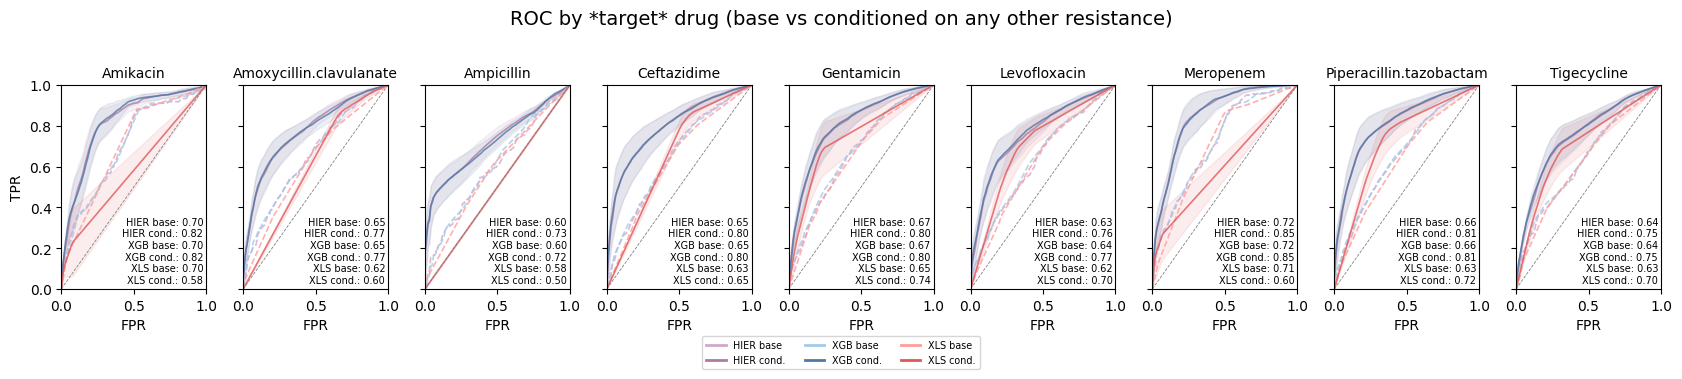

In [ ]:
##############################################################################
# 5.  Mean ROC – grouped by *target* drug (10 sub‑plots) #####################
##############################################################################
import matplotlib.pyplot as plt, numpy as np, math, seaborn as sns

# ── 5‑A.  Setup -------------------------------------------------------------
colours  = [  "#4E79A7", '#A0CBE8', '#B07AA1', '#D4A6C8',# '#499894', '#86BCB6',
            # '#59A14F', '#8CD17D',
            '#E15759', '#FF9D9A']
families = ["HIER", "XGB", "XLS"]
family_stores = {
    # "FIXED": roc_store_fixed,
    "HIER":  roc_store_hier,
    "XGB":   roc_store_xgb,
    # "LR":    roc_store_lr,
    "XLS":   roc_store_xls,
}
family_colours = {f: (colours[i*2+1], colours[i*2]) for i, f in enumerate(families)}

# pick 10 target drugs
tgt_drugs = sorted(drug_cols)[:10]
n_panels  = len(tgt_drugs)
ncols, nrows = 9, 1

base_fpr = np.linspace(0, 1, 101)
fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(2 * ncols, 3.8 * nrows),
    sharex=True, sharey=True,
)
axes = axes.flatten()
legend_h, legend_l = [], []

# ── 5‑B.  Loop over target drugs -------------------------------------------
for idx, tgt in enumerate(tgt_drugs):
    ax = axes[idx]
    auc_lines = []

    for fam in families:
        store        = family_stores[fam]
        light, dark  = family_colours[fam]

        # (i)  BASE (unconditioned) curve for that target
        if tgt not in store[None]:
            continue                      # target missing
        fpr_b, tpr_b, auc_b = store[None][tgt]
        mean_b = np.interp(base_fpr, fpr_b, tpr_b)  # single curve
        ax.plot(base_fpr, mean_b, color=light, lw=1.2, ls="--", alpha=0.8)

        # (ii) CONDITIONED curves for that target across *all* cond ≠ None,≠ tgt
        tpr_c_list, auc_c_vals = [], []
        for cond, cond_dict in store.items():
            if cond is None or cond == tgt or tgt not in cond_dict:
                continue
            fpr, tpr, auc_val = cond_dict[tgt]
            tpr_c_list.append(np.interp(base_fpr, fpr, tpr))
            auc_c_vals.append(auc_val)

        if tpr_c_list:                    # might be empty if data missing
            tpr_c = np.vstack(tpr_c_list)
            mean_c = tpr_c.mean(axis=0)
            se_c   = tpr_c.std(axis=0, ddof=1) / np.sqrt(tpr_c.shape[0])
            ci_lo_c = np.maximum(mean_c - 1.96*se_c, 0)
            ci_hi_c = np.minimum(mean_c + 1.96*se_c, 1)
            auc_c = np.mean(auc_c_vals)

            ax.plot(base_fpr, mean_c, color=dark, lw=1.2, ls="-", alpha=0.8)
            ax.fill_between(base_fpr, ci_lo_c, ci_hi_c, color=dark, alpha=0.1)
        else:
            auc_c = np.nan

        auc_lines.append(f"{fam} base: {auc_b:.2f}")
        if not np.isnan(auc_c):
            auc_lines.append(f"{fam} cond.: {auc_c:.2f}")

        # store legend handles once (first panel only)
        if idx == 0:
            legend_h += [plt.Line2D([0], [0], color=light, lw=2),
                          plt.Line2D([0], [0], color=dark,  lw=2)]
            legend_l += [f"{fam} base", f"{fam} cond."]

    ax.plot([0, 1], [0, 1], "--", lw=0.6, color="grey")
    ax.set_title(tgt, fontsize=10)
    if idx % ncols == 0:
        ax.set_ylabel("TPR")
    if idx >= (nrows - 1) * ncols:
        ax.set_xlabel("FPR")
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)

    ax.text(
        0.98, 0.02, "\n".join(auc_lines),
        transform=ax.transAxes, fontsize=7,
        va="bottom", ha="right",
        bbox=dict(boxstyle="round,pad=0.2",
                    facecolor="white", alpha=0.6, lw=0)
    )

# hide unused axes (if <10 targets)
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

fig.legend(
    legend_h, legend_l,
    ncol=len(families), fontsize="x-small",
    loc="lower center", bbox_to_anchor=(0.5, -0.02),
)
fig.suptitle("ROC by *target* drug (base vs conditioned on any other resistance)",
             y=0.94, fontsize=14)
fig.tight_layout(rect=[0.03, 0.05, 0.97, 0.92])
plt.savefig("roc_10_target_drugs.png", dpi=300)
plt.show()


Loading hier family, conditioning drug: None, file: ../../results/predictions_non_ml/hier/hier.csv
Loading hier family, conditioning drug: Meropenem, file: ../../results/predictions_non_ml/hier/Meropenem_hier.csv
Loading hier family, conditioning drug: Piperacillin.tazobactam, file: ../../results/predictions_non_ml/hier/Piperacillin.tazobactam_hier.csv
Loading hier family, conditioning drug: Ampicillin, file: ../../results/predictions_non_ml/hier/Ampicillin_hier.csv
Loading hier family, conditioning drug: Tigecycline, file: ../../results/predictions_non_ml/hier/Tigecycline_hier.csv
Loading hier family, conditioning drug: Gentamicin, file: ../../results/predictions_non_ml/hier/Gentamicin_hier.csv
Loading hier family, conditioning drug: Amikacin, file: ../../results/predictions_non_ml/hier/Amikacin_hier.csv
Loading hier family, conditioning drug: Ceftazidime, file: ../../results/predictions_non_ml/hier/Ceftazidime_hier.csv
Loading hier family, conditioning drug: Levofloxacin, file: ../..

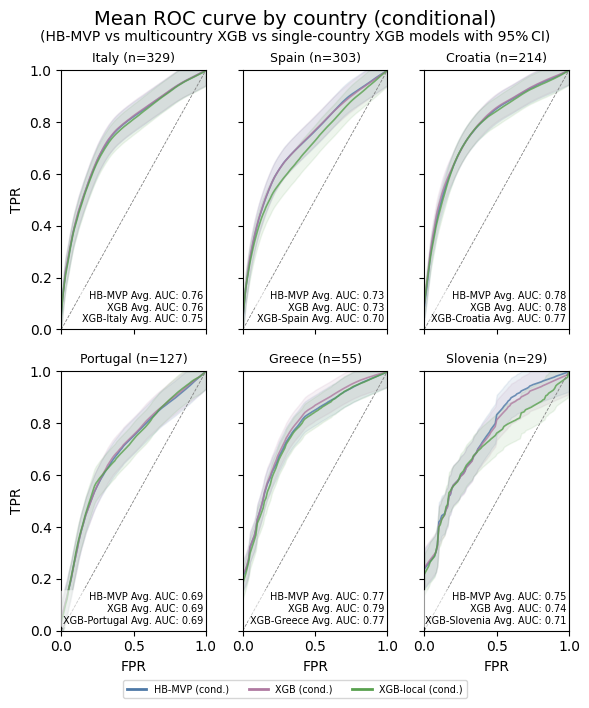

In [191]:
##############################################################################
# 5.  Mean ROC – grouped by *country* (9 sub‑plots) + country‑specific XGB ###
##############################################################################
import matplotlib.pyplot as plt, numpy as np, seaborn as sns, math, os, pandas as pd
from functools import lru_cache
from sklearn.metrics import roc_curve, auc

# ── 5‑A.  Families & colours ------------------------------------------------
# global models
families = ["HIER", "XGB"]
global_colours = ["#4E79A7", '#A0CBE8', # HIER   (light,dark)
                   '#B07AA1', '#D4A6C8',  # XGB
                  '#E15759', '#FF9D9A']  # XLS
family_colours = {f: (global_colours[i*2+1], global_colours[i*2])
                  for i, f in enumerate(families)}

global_stores = {"HIER": roc_store_hier,
                 "XGB":  roc_store_xgb}


label_names = {
    "HIER":  "HB-MVP",
    "XGB":   "XGB",
    "XGB_Italy": "XGB Single Country",
    "XGB_Spain": "XGB Single Country",
    "XGB_Croatia": "XGB Single Country",
    "XGB_Portugal": "XGB Single Country",
    "XGB_Greece": "XGB Single Country",
    "XGB_Slovenia": "XGB Single Country",
    "LR":    "LR",
    "XLS":   "PA",
}

# add a *single* colour pair for every country‑specific XGB
loc_light, loc_dark = "#8CD17D", "#59A14F"             # light / dark green

# ── 5‑B.  Country list (largest 9) ------------------------------------------------
base_df   = _load_frame("hier", None)
country_n = base_df.groupby("country").size().sort_values(ascending=False)
countries = country_n.index[:9].tolist()  # top 9 countries by number of rows

ncols, nrows = 3, 2
base_fpr = np.linspace(0, 1, 101)

# cache global CSV reads
@lru_cache(maxsize=None)
def _frame(family, cond):
    return _load_frame(family, cond)

# helper to read a country‑specific XGB CSV
def _frame_local(country, cond):
    folder = f"../../results/predictions_ml/xgb_{country}"
    fname  = f"xgb_{country}.csv" if cond is None else f"{cond}_xgb_{country}.csv"
    path   = os.path.join(folder, fname)
    if not os.path.isfile(path):
        raise FileNotFoundError(path)
    return pd.read_csv(path)

# ── 5‑C.  Figure grid -------------------------------------------------------
fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(6, 7),
    sharex=True, sharey=True
)
plt.tight_layout()
axes = axes.flatten()
legend_h, legend_l = [], []

# ── 5‑D.  Loop over countries ----------------------------------------------
for idx, ctry in enumerate(countries):
    ax = axes[idx]
    auc_lines = []

    # -------- global families (HIER, XGB, XLS) ------------------------------
    for fam in families:
        light, dark = family_colours[fam]

        # # base (unconditioned)
        # tprs_b, auc_b = [], []
        # df_b = _frame(fam.lower(), None)
        # df_b = df_b[df_b["country"] == ctry]
        # for tgt in drug_cols:
        #     bin_col = f"{tgt}_bin"
        #     if bin_col not in df_b or len(np.unique(df_b[bin_col])) < 2:
        #         continue
        #     fpr, tpr, _ = roc_curve(df_b[bin_col], df_b[f"{tgt}_pred_prob"])
        #     tprs_b.append(np.interp(base_fpr, fpr, tpr))
        #     auc_b.append(auc(fpr, tpr))
        # if tprs_b:
        #     ax.plot(base_fpr, np.vstack(tprs_b).mean(0),
        #             color=light, lw=1.2, ls="--", alpha=0.8)
        #     auc_lines.append(f"{fam} base: {np.mean(auc_b):.2f}")

        # conditioned (mean over all cond ≠ None)
        tprs_c, auc_c = [], []
        for cond in drug_cols:
            df_c = _frame(fam.lower(), cond)
            df_c = df_c[df_c["country"] == ctry]
            for tgt in drug_cols:
                if tgt == cond: continue
                bin_col = f"{tgt}_bin"
                prob_col = f"{tgt}_{cond}_pred_prob"
                if prob_col not in df_c or len(np.unique(df_c[bin_col])) < 2:
                    continue
                fpr, tpr, _ = roc_curve(df_c[bin_col], df_c[prob_col])
                tprs_c.append(np.interp(base_fpr, fpr, tpr))
                auc_c.append(auc(fpr, tpr))
        if tprs_c:
            mean_c = np.vstack(tprs_c).mean(0)
            se_c   = np.std(tprs_c, ddof=1) / np.sqrt(len(tprs_c))
            ax.plot(base_fpr, mean_c, color=dark, lw=1.2, alpha=0.8)
            ax.fill_between(base_fpr,
                            np.maximum(mean_c - 1.96*se_c, 0),
                            np.minimum(mean_c + 1.96*se_c, 1),
                            color=dark, alpha=0.1)
            auc_lines.append(f"{label_names.get(fam)} Avg. AUC: {np.mean(auc_c):.2f}")

        if idx == 0:
            # legend_h += [plt.Line2D([0], [0], color=light, lw=2),
            #              plt.Line2D([0], [0], color=dark,  lw=2)]
            # legend_l += [f"{fam} base", f"{fam} cond."]
            legend_h += [plt.Line2D([0], [0], color=dark,  lw=2)]
            legend_l += [f"{label_names.get(fam)} (cond.)"]

    # -------- country‑specific XGB -----------------------------------------
    try:
        # # base
        # tprs_b_loc, auc_b_loc = [], []
        # df_loc_b = _frame_local(ctry, None)
        # for tgt in drug_cols:
        #     bin_col = f"{tgt}_bin"
        #     if bin_col not in df_loc_b or len(np.unique(df_loc_b[bin_col])) < 2:
        #         continue
        #     fpr, tpr, _ = roc_curve(df_loc_b[bin_col], df_loc_b[f"{tgt}_pred_prob"])
        #     tprs_b_loc.append(np.interp(base_fpr, fpr, tpr))
        #     auc_b_loc.append(auc(fpr, tpr))
        # if tprs_b_loc:
        #     ax.plot(base_fpr, np.vstack(tprs_b_loc).mean(0),
        #             color=loc_light, lw=1.2, ls="--", alpha=0.8)
        #     auc_lines.append(f"XGB‑{ctry} base: {np.mean(auc_b_loc):.2f}")

        # conditioned
        tprs_c_loc, auc_c_loc = [], []
        for cond in drug_cols:
            df_loc_c = _frame_local(ctry, cond)
            for tgt in drug_cols:
                if tgt == cond: continue
                bin_col  = f"{tgt}_bin"
                prob_col = f"{tgt}_{cond}_pred_prob"
                if prob_col not in df_loc_c or len(np.unique(df_loc_c[bin_col])) < 2:
                    continue
                fpr, tpr, _ = roc_curve(df_loc_c[bin_col], df_loc_c[prob_col])
                tprs_c_loc.append(np.interp(base_fpr, fpr, tpr))
                auc_c_loc.append(auc(fpr, tpr))
        if tprs_c_loc:
            mean_c_loc = np.vstack(tprs_c_loc).mean(0)
            se_c_loc   = np.std(tprs_c_loc, ddof=1) / np.sqrt(len(tprs_c_loc))
            ax.plot(base_fpr, mean_c_loc, color=loc_dark, lw=1.2, alpha=0.8)
            ax.fill_between(base_fpr,
                            np.maximum(mean_c_loc - 1.96*se_c_loc, 0),
                            np.minimum(mean_c_loc + 1.96*se_c_loc, 1),
                            color=loc_dark, alpha=0.1)
            auc_lines.append(f"XGB‑{ctry} Avg. AUC: {np.mean(auc_c_loc):.2f}")

        if idx == 0:
            # legend_h += [plt.Line2D([0], [0], color=loc_light, lw=2),
            #              plt.Line2D([0], [0], color=loc_dark,  lw=2)]
            # legend_l += [f"XGB‑local base", f"XGB‑local cond."]
            legend_h += [plt.Line2D([0], [0], color=loc_dark,  lw=2)]
            legend_l += [f"XGB‑local (cond.)"]

    except FileNotFoundError:
        # no country‑specific folder – silently skip
        pass

    # -------- panel cosmetics ---------------------------------------------
    ax.plot([0, 1], [0, 1], "--", lw=0.6, color="grey")
    ax.set_title(f"{ctry} (n={country_n[ctry]})", fontsize=9)
    if idx % ncols == 0:          ax.set_ylabel("TPR")
    if idx >= (nrows - 1)*ncols:  ax.set_xlabel("FPR")
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.text(0.98, 0.02, "\n".join(auc_lines),
            transform=ax.transAxes, fontsize=7,
            va="bottom", ha="right",
            bbox=dict(boxstyle="round,pad=0.2",
                      facecolor="white", alpha=0.6, lw=0))

# blank unused axes
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

# ── 5‑E.  Shared legend & final touches ------------------------------------
fig.legend(legend_h, legend_l,
           ncol=4, fontsize="x-small",
           loc="lower center", bbox_to_anchor=(0.5, -0.02))
# First line (larger)
fig.suptitle("Mean ROC curve by country (conditional)", fontsize=14, y=0.97)
# Second line (smaller) – place it just below the first one
fig.text(0.5, 0.925,
         "(HB‑MVP vs multicountry XGB vs single‑country XGB models with 95% CI)",
         ha='center', fontsize=10)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("roc_by_country_with_local.png", dpi=300)
plt.show()


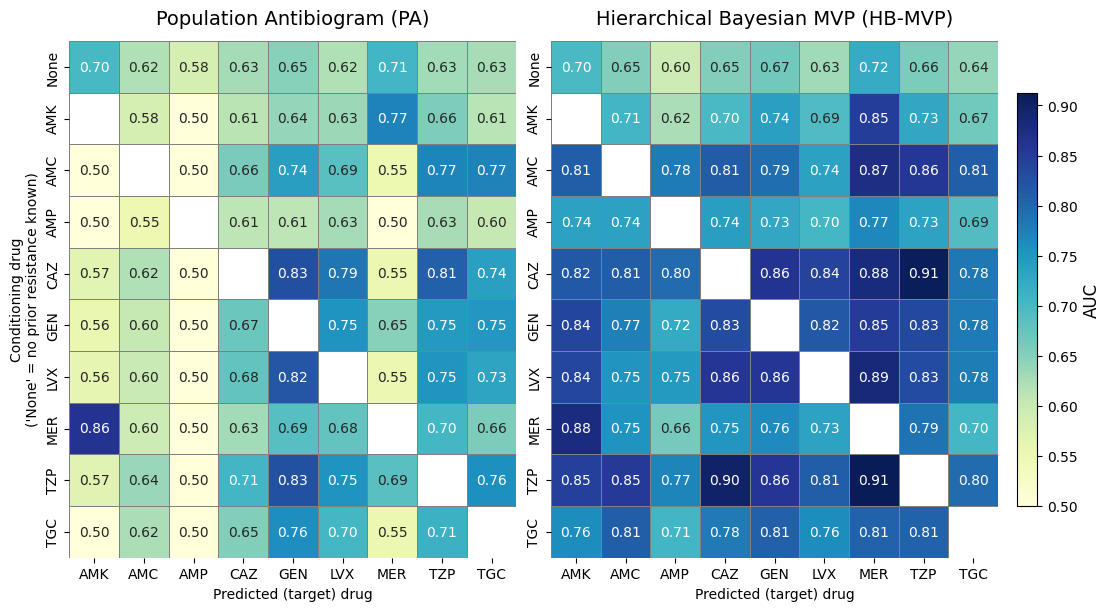

In [243]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Abbreviation map
DRUG_ABBR = {
    "Meropenem": "MER",
    "Piperacillin.tazobactam": "TZP",
    "Ampicillin": "AMP",
    "Tigecycline": "TGC",
    "Gentamicin": "GEN",
    "Amikacin": "AMK",
    "Ceftazidime": "CAZ",
    "Levofloxacin": "LVX",
    "Colistin": "CST",
    "Amoxycillin.clavulanate": "AMC"
}

def build_auc_matrix(roc_dict, drug_cols, conditioning_choices):
    """Return a DataFrame [conditioning]×[target] filled with AUC values."""
    cond_labels = ["None"] + drug_cols
    auc_mat = pd.DataFrame(index=cond_labels, columns=drug_cols, dtype=float)

    for cond in conditioning_choices:                      # None + drugs
        row_name = "None" if cond is None else cond
        for tgt, (_, _, auc_val) in roc_dict[cond].items():
            auc_mat.loc[row_name, tgt] = auc_val           # NaN where ROC missing
    return auc_mat

def abbreviate_df_labels(df):
    """Return a copy of df with rows/columns renamed using abbreviations."""
    df = df.copy()
    df.index = ["None" if i == "None" else DRUG_ABBR.get(i, i) for i in df.index]
    df.columns = [DRUG_ABBR.get(i, i) for i in df.columns]
    return df

def plot_auc_heatmaps_subplots(auc_dicts, titles, save_as=None):
    """Plot AUC heatmaps side-by-side from a list of matrices."""
    num_plots = len(auc_dicts)
    fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots -1, 6), constrained_layout=True)

    # Compute global color scale
    vmin = 0.50
    vmax = np.nanmax([df.values for df in auc_dicts])

    heatmaps = []
    for ax, df, title in zip(axes, auc_dicts, titles):
        hm = sns.heatmap(
            df,
            annot=True,
            fmt=".2f",
            cmap="YlGnBu",
            vmin=vmin,
            vmax=vmax,
            linewidths=0.4,
            linecolor="grey",
            annot_kws={"size": 10},
            mask=df.isna(),
            cbar=False,
            ax=ax
        )
        heatmaps.append(hm)
        ax.set_title(title, fontsize=14, pad=12)
        ax.set_xlabel("Predicted (target) drug")
        # check if current axis is the first one to set y-label
        if ax == axes[0]:
            ax.set_ylabel("Conditioning drug\n('None' = no prior resistance known)")

    # Add a single colorbar to the right
    cbar = fig.colorbar(heatmaps[0].collections[0], ax=axes, location='right', shrink=0.8, pad=0.02)
    cbar.set_label("AUC", fontsize=12)

    if save_as:
        plt.savefig(save_as, dpi=300, bbox_inches="tight")
    plt.show()

# Example usage assuming you have three ROC dictionaries
# Replace roc_store_fixed / _hier / _xgb and drug_cols accordingly

auc_hier = build_auc_matrix(roc_store_hier, drug_cols, conditioning_choices)
# auc_xgb = build_auc_matrix(roc_store_xgb, drug_cols, conditioning_choices)
auc_xls = build_auc_matrix(roc_store_xls, drug_cols, conditioning_choices)

# Abbreviate labels
auc_hier_abbr = abbreviate_df_labels(auc_hier)
# auc_xgb_abbr = abbreviate_df_labels(auc_xgb)
auc_xls_abbr = abbreviate_df_labels(auc_xls)

# Plot all four as subplots
plot_auc_heatmaps_subplots(
    auc_dicts=[auc_xls_abbr, auc_hier_abbr ],
    titles=["Population Antibiogram (PA)", "Hierarchical Bayesian MVP (HB-MVP)" ],
    save_as="heatmaps_auc_models.png"
)


In [45]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import numpy as np, re, pandas as pd

THRESH = 0.50          # global threshold for converting probabilities → labels

def _prob_col(target, cond, family):
    """(unchanged helper)"""
    raw = f"{target}_pred_prob" if cond is None else f"{target}_{cond}_pred_prob"
    return re.sub(r"__pred_prob$", "_pred_prob", raw)

def _to_binary(vec, thresh=THRESH):
    """
    Ensure a 1‑D numpy array is binary (0/1):
      * If it already contains only {0,1} return as‑is.
      * Otherwise threshold at 'thresh'.
    """
    vec = np.asarray(vec)
    if set(np.unique(vec)) <= {0, 1}:      # already binary
        return vec.astype(int)
    return (vec >= thresh).astype(int)     # threshold continuous probs

def metrics_for_family(family):
    """
    Build nested dicts of ACC and BACC:
        store[conditioning_drug][target_drug] = float
    """
    acc_store, bacc_store = {}, {}

    for cond in conditioning_choices:                      # None + 9 drugs
        df          = _load_frame(family, cond)            # ← your existing helper
        acc_dict    = {}
        bacc_dict   = {}

        for tgt in (d for d in drug_cols if d != cond):
            y_true = df[f"{tgt}_bin"].values
            if len(np.unique(y_true)) < 2:                 # skip degenerate ROC
                continue

            # ── pull predictions (hard label or probability) ────────────────
            if f"{tgt}_pred_y" in df.columns:
                y_pred = df[f"{tgt}_pred_y"].values
            else:
                pcol = _prob_col(tgt, cond, family)
                if pcol not in df.columns:
                    continue                               # nothing to score
                y_pred = df[pcol].values

            # ── drop rows containing NaNs simultaneously in y_true / y_pred ─
            mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
            if mask.sum() == 0:
                continue
            y_true_clean = y_true[mask]
            y_pred_clean = _to_binary(y_pred[mask])

            acc_dict[tgt]  = accuracy_score(y_true_clean, y_pred_clean)
            bacc_dict[tgt] = balanced_accuracy_score(y_true_clean, y_pred_clean)

        acc_store[cond]  = acc_dict
        bacc_store[cond] = bacc_dict

    return acc_store, bacc_store


# build once for each family you care about
acc_store_hier,  bacc_store_hier  = metrics_for_family("hier")
acc_store_xgb,   bacc_store_xgb   = metrics_for_family("xgb")
acc_store_xls,   bacc_store_xls   = metrics_for_family("xls")
# …and so on for "fixed", "lr", country‑specific XGB families, etc.

Loading hier family, conditioning drug: None, file: ../../results/predictions_non_ml/hier/hier.csv
Loading hier family, conditioning drug: Meropenem, file: ../../results/predictions_non_ml/hier/Meropenem_hier.csv
Loading hier family, conditioning drug: Piperacillin.tazobactam, file: ../../results/predictions_non_ml/hier/Piperacillin.tazobactam_hier.csv
Loading hier family, conditioning drug: Ampicillin, file: ../../results/predictions_non_ml/hier/Ampicillin_hier.csv
Loading hier family, conditioning drug: Tigecycline, file: ../../results/predictions_non_ml/hier/Tigecycline_hier.csv
Loading hier family, conditioning drug: Gentamicin, file: ../../results/predictions_non_ml/hier/Gentamicin_hier.csv
Loading hier family, conditioning drug: Amikacin, file: ../../results/predictions_non_ml/hier/Amikacin_hier.csv
Loading hier family, conditioning drug: Ceftazidime, file: ../../results/predictions_non_ml/hier/Ceftazidime_hier.csv
Loading hier family, conditioning drug: Levofloxacin, file: ../..

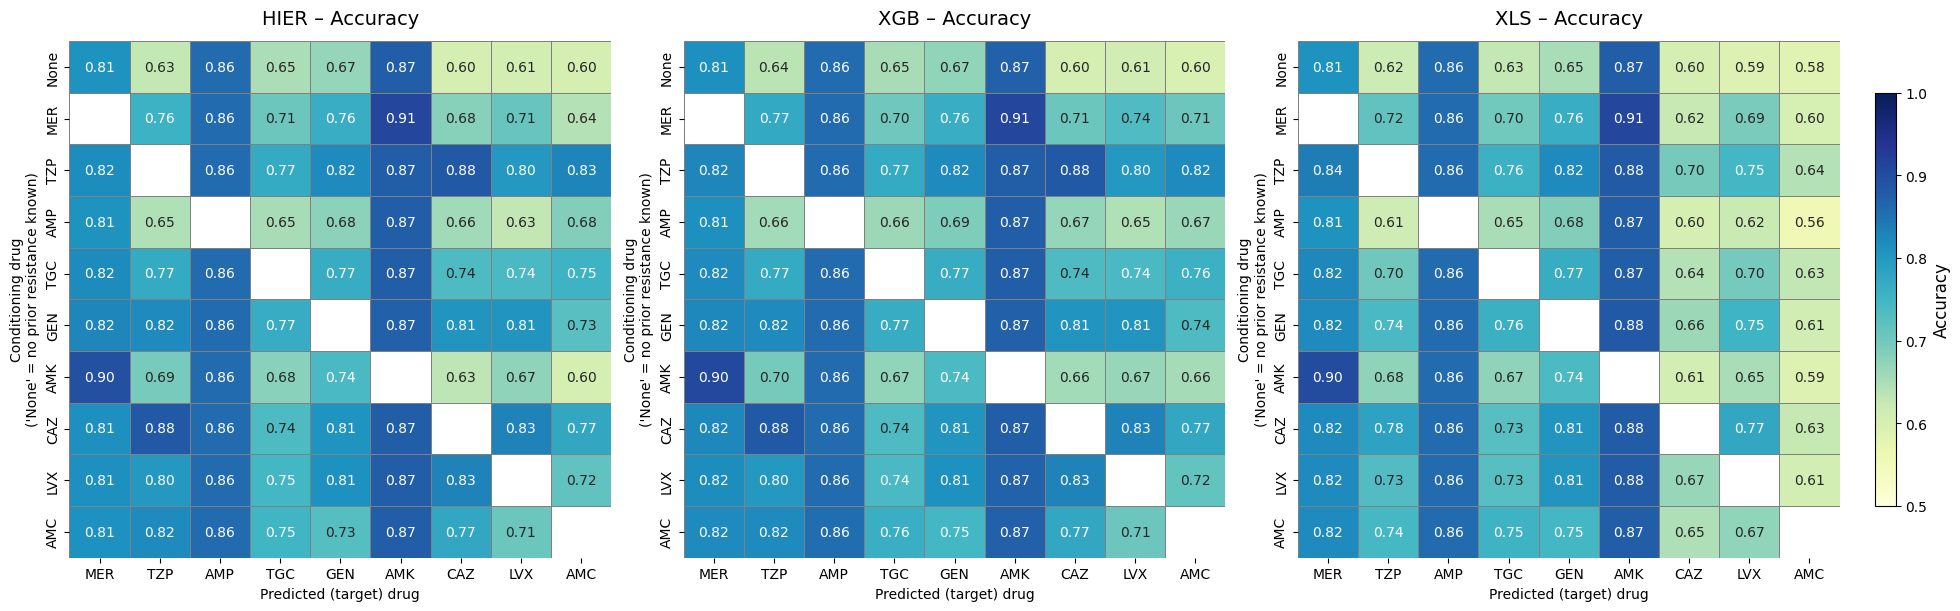

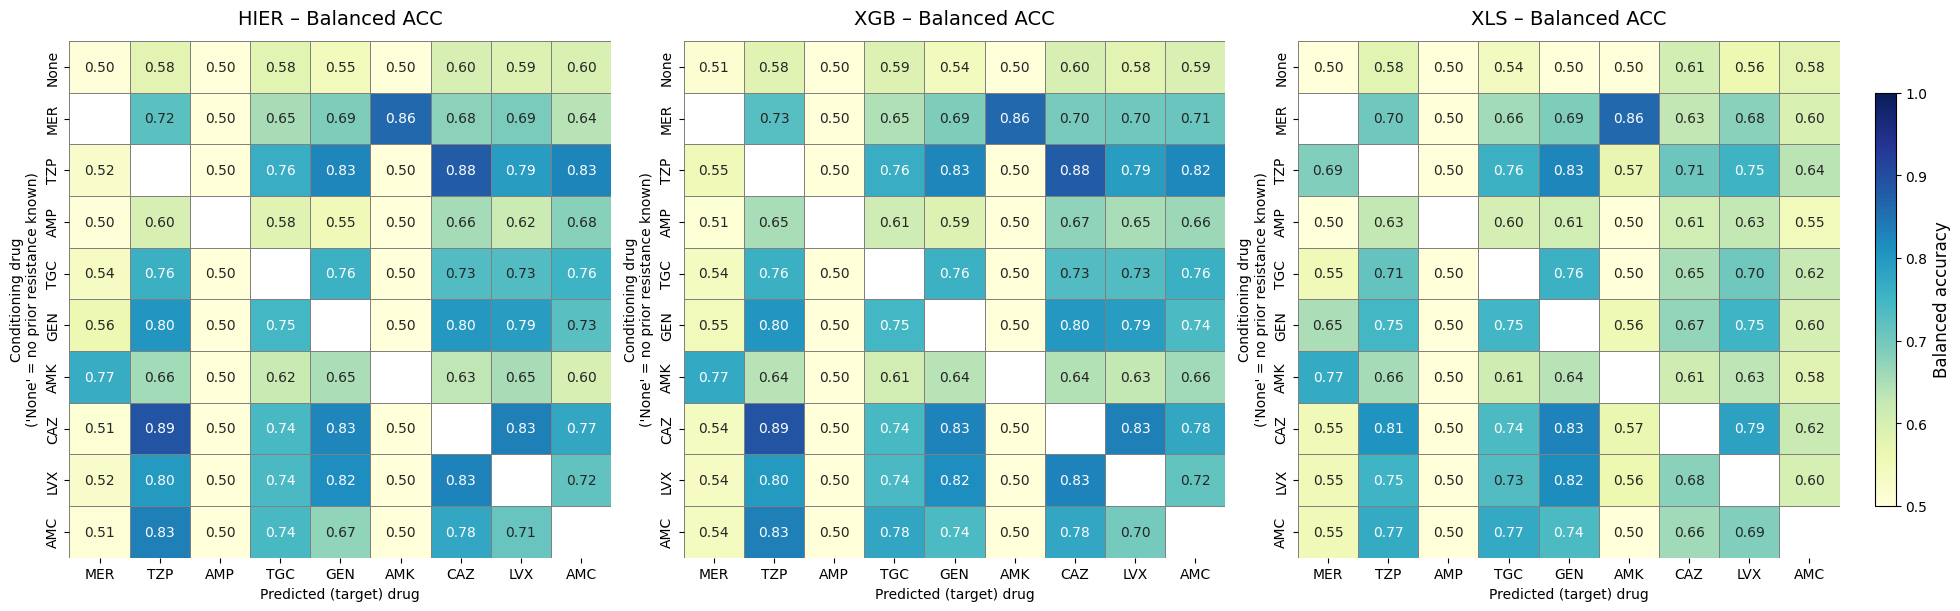

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ─────────────────────────────────────────────────────────────────────────────
# 1. Drug‑name → 3‑letter code map
# ─────────────────────────────────────────────────────────────────────────────
DRUG_ABBR = {
    "Meropenem": "MER",
    "Piperacillin.tazobactam": "TZP",
    "Ampicillin": "AMP",
    "Tigecycline": "TGC",
    "Gentamicin": "GEN",
    "Amikacin": "AMK",
    "Ceftazidime": "CAZ",
    "Levofloxacin": "LVX",
    "Colistin": "CST",
    "Amoxycillin.clavulanate": "AMC",
}

# ─────────────────────────────────────────────────────────────────────────────
# 2. Matrix builders  ── generic for any metric store
#    ▸ metric_store[cond][tgt] = single float value
#      (if your store still contains tuples, pull out the relevant element first)
# ─────────────────────────────────────────────────────────────────────────────
def build_metric_matrix(metric_store, drug_cols, conditioning_choices):
    """Return DataFrame [conditioning]×[target] filled with metric values."""
    cond_labels = ["None"] + drug_cols
    mat = pd.DataFrame(index=cond_labels, columns=drug_cols, dtype=float)

    for cond in conditioning_choices:          # loop None + drugs used as conditioning
        row_name = "None" if cond is None else cond
        for tgt, metric_val in metric_store[cond].items():
            mat.loc[row_name, tgt] = metric_val
    return mat


def abbreviate_df_labels(df):
    """Rename rows/columns to 3‑letter codes (keep 'None' unchanged)."""
    df = df.copy()
    df.index = ["None" if i == "None" else DRUG_ABBR.get(i, i) for i in df.index]
    df.columns = [DRUG_ABBR.get(i, i) for i in df.columns]
    return df


# ─────────────────────────────────────────────────────────────────────────────
# 3. Generic heat‑map plotter with external colour‑bar
# ─────────────────────────────────────────────────────────────────────────────
def plot_metric_heatmaps_subplots(mats, titles, cbar_label, vmin=None, vmax=None,
                                  cmap="YlGnBu", save_as=None):
    """Draw side‑by‑side heat‑maps with one shared colour‑bar outside."""
    n = len(mats)
    fig, axes = plt.subplots(1, n, figsize=(6 * n + 1.5, 6), constrained_layout=True)

    # Consistent colour scale
    if vmin is None:
        vmin = np.nanmin([m.values for m in mats])
    if vmax is None:
        vmax = np.nanmax([m.values for m in mats])

    hm_list = []
    for ax, df, ttl in zip(axes, mats, titles):
        hm = sns.heatmap(
            df,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            linewidths=0.4,
            linecolor="grey",
            mask=df.isna(),
            cbar=False,
            ax=ax
        )
        hm_list.append(hm)
        ax.set_title(ttl, fontsize=14, pad=12)
        ax.set_xlabel("Predicted (target) drug")
        ax.set_ylabel("Conditioning drug\n('None' = no prior resistance known)")

    # Shared colour‑bar
    cbar = fig.colorbar(hm_list[0].collections[0], ax=axes,
                        location="right", shrink=0.8, pad=0.02)
    cbar.set_label(cbar_label, fontsize=12)

    if save_as:
        plt.savefig(save_as, dpi=300, bbox_inches="tight")
    plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# 4. Build matrices for ACC and BACC, then plot
# ─────────────────────────────────────────────────────────────────────────────
# Supply your own lists/sets:
#   ▸ drug_cols           : list of 9 target‑drug names in canonical form
#   ▸ conditioning_choices: [None] + the 9 drug names used for conditioning
#   ▸ acc_store_*         : dicts for accuracy
#   ▸ bacc_store_*        : dicts for balanced accuracy

# ----- ACCURACY --------------------------------------------------------------
acc_hier = build_metric_matrix(acc_store_hier, drug_cols, conditioning_choices)
acc_xgb  = build_metric_matrix(acc_store_xgb,  drug_cols, conditioning_choices)
acc_xls  = build_metric_matrix(acc_store_xls,  drug_cols, conditioning_choices)

acc_hier_abbr = abbreviate_df_labels(acc_hier)
acc_xgb_abbr  = abbreviate_df_labels(acc_xgb)
acc_xls_abbr  = abbreviate_df_labels(acc_xls)

plot_metric_heatmaps_subplots(
    mats   =[acc_hier_abbr, acc_xgb_abbr, acc_xls_abbr],
    titles =["HIER – Accuracy", "XGB – Accuracy", "XLS – Accuracy"],
    cbar_label="Accuracy",
    vmin=0.5,   # start colour‑scale at chance level – tweak if you prefer
    vmax=1.0,
    save_as="heatmaps_accuracy_models.png"
)

# ----- BALANCED ACCURACY -----------------------------------------------------
bacc_hier = build_metric_matrix(bacc_store_hier, drug_cols, conditioning_choices)
bacc_xgb  = build_metric_matrix(bacc_store_xgb,  drug_cols, conditioning_choices)
bacc_xls  = build_metric_matrix(bacc_store_xls,  drug_cols, conditioning_choices)

bacc_hier_abbr = abbreviate_df_labels(bacc_hier)
bacc_xgb_abbr  = abbreviate_df_labels(bacc_xgb)
bacc_xls_abbr  = abbreviate_df_labels(bacc_xls)

plot_metric_heatmaps_subplots(
    mats   =[bacc_hier_abbr, bacc_xgb_abbr, bacc_xls_abbr],
    titles =["HIER – Balanced ACC", "XGB – Balanced ACC", "XLS – Balanced ACC"],
    cbar_label="Balanced accuracy",
    vmin=0.5,  # chance level for balanced accuracy
    vmax=1.0,
    save_as="heatmaps_balanced_accuracy_models.png"
)


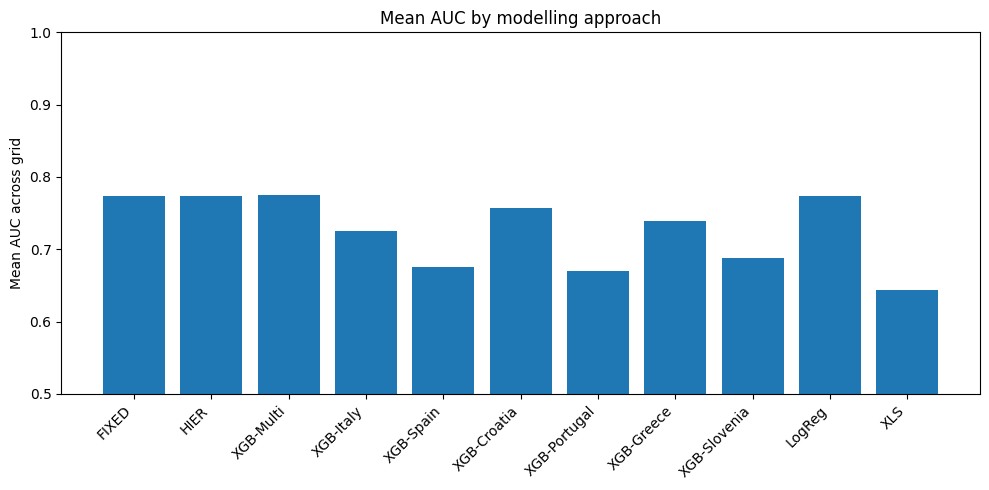

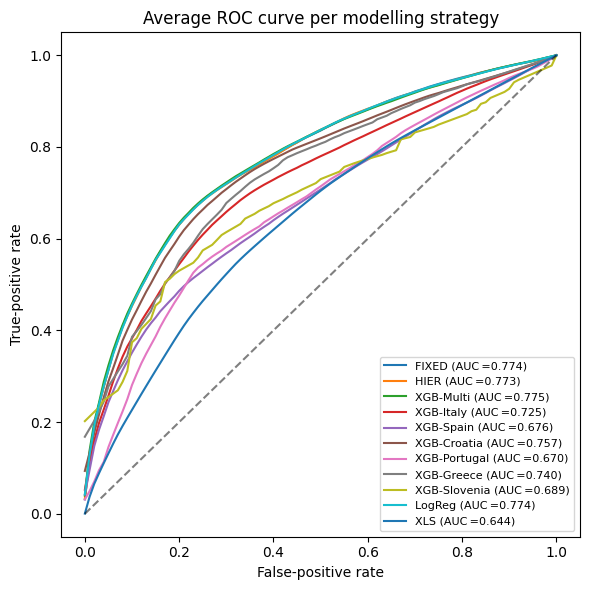

In [192]:
##############################################################################
# 5.  Collate the grid averages into one figure
##############################################################################
import matplotlib.pyplot as plt

# --- helper to collapse the roc_store into a single mean AUC ---------------
def mean_auc(roc_store):
    """Return (mean_auc, n_curves) for a roc_store"""
    aucs = [
        curve[2]                         # (fpr,tpr,auc) → auc
        for curves_per_cond in roc_store.values()
        for curve in curves_per_cond.values()
    ]
    if not aucs:
        return np.nan, 0
    return np.mean(aucs), len(aucs)

# --- helper to create an *average* ROC curve (optional, for line plot) -----
def average_roc(roc_store, n_points=101):
    base_fpr  = np.linspace(0, 1, n_points)
    sum_tpr   = np.zeros_like(base_fpr)
    n_curves  = 0

    for curves_per_cond in roc_store.values():
        for fpr, tpr, _ in curves_per_cond.values():
            sum_tpr += np.interp(base_fpr, fpr, tpr)
            n_curves += 1

    if n_curves == 0:
        return base_fpr, np.zeros_like(base_fpr), np.nan
    mean_tpr = sum_tpr / n_curves
    return base_fpr, mean_tpr, auc(base_fpr, mean_tpr)

# ---------------------------------------------------------------------------
# 5‑A.  Collect the numbers you care about
model_stores = {
    "FIXED":          roc_store_fixed,
    "HIER":           roc_store_hier,
    "XGB‑Multi":      roc_store_xgb,
    "XGB‑Italy":      roc_store_xgb_Italy,
    "XGB‑Spain":      roc_store_xgb_Spain,
    "XGB‑Croatia":    roc_store_xgb_Croatia,
    "XGB‑Portugal":   roc_store_xgb_Portugal,
    "XGB‑Greece":     roc_store_xgb_Greece,
    "XGB‑Slovenia":   roc_store_xgb_Slovenia,
    "LogReg":         roc_store_lr,
    "XLS":            roc_store_xls,
}

mean_auc_vals = {name: mean_auc(store)[0] for name, store in model_stores.items()}

##############################################################################
# 5‑B‑1.  BAR PLOT of mean AUCs  (quick & simple) ---------------------------
##############################################################################
plt.figure(figsize=(10, 5))
names  = list(mean_auc_vals.keys())
values = [mean_auc_vals[n] for n in names]

plt.bar(names, values)
plt.ylabel("Mean AUC across grid")
plt.xticks(rotation=45, ha="right")
plt.ylim(0.5, 1.0)
plt.title("Mean AUC by modelling approach")
plt.tight_layout()
plt.savefig("mean_auc_all_models.png", dpi=300)
plt.show()

##############################################################################
# 5‑B‑2.  (OPTIONAL) Multi‑line figure of *average ROC curves* --------------
##############################################################################
plt.figure(figsize=(6, 6))
for name, store in model_stores.items():
    fpr, tpr, avg_auc = average_roc(store)
    plt.plot(fpr, tpr, label=f"{name} (AUC ={avg_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", alpha=.5)
plt.xlabel("False‑positive rate")
plt.ylabel("True‑positive rate")
plt.title("Average ROC curve per modelling strategy")
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig("average_roc_all_models.png", dpi=300)
plt.show()
